# Consistency Assessment of the Atlas Underpinning Dataset with Original #WIP

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**
Production date: DD-MM-YYYY
Dataset version: 2.0.
Produced by: C3S2_521 contract.

## 🌍 Use case: Consistency of the tx35 indicator from the Gridded Dataset Underpinning the Copernicus Interactive Climate Atlas in comparison with the tx35 indicator from the CMIP6 CLimate Projections dataset

## ❓ Quality assessment question
* **Are the output indexes consistent between the Gridded Dataset Underpinning the Copernicus Interactive Climate Atlas and the CMIP6 Climate Projections dataset?**
* **etc**

This box will be the introduction to the assessment, including:
- Purpose and aims of the assessment. 
- 

(NOTE: need to find the correct terminology when referring to the non-Atlas datasets throughout this, option: original origin datasets, non-Atlas datasets, ...  have chosen origin datasets)

The purpose of this assessment is to evaluate the consistency between the Gridded Dataset Underpinning the Copernicus Interactive Climate Atlas (Atlas dataset hereafter) and the origin datasets. This is done through 


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1: will be a statement on the findings regarding the consistency 
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology

To include:
- *Dimensions of the Atlas dataset and the rationale behind the scope of this assessment*
Due to the extend of the Atlas

- Justification for the assessment being performed (justification for the t.b.d metric chosen also)
- Methodology used, i.e. each step:
  
      - Download model data
  
      - Set parameters (variable, time, location)
  
      - Load data
  
      - Homogenisation to match Atlas dataset
  
      - Calculate the index
  
      - Interpolate to a common and regular grid
  
      - Download coresponding Atlas dataset data
  
      - Analyse results
          - plots 
          - similarity/comparison metric
          - results matrix 

This Jupyter notebook is currently a test case to build the workflow. We have chosen to reproduce the [Monthly count of days with maximum near-surface air temperature above 35 deg](https://ecmwf-projects.github.io/c3s-atlas/notebooks/tx35.html) notebook as an initial test. 

**[](section-1)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-2)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-3)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-4)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.
 
**[](section-5)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-6)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-7)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-8)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-1)=
### 1. Set-up 
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for 
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) 
and 
visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the C3S Atlas User Tools
This notebook uses the [C3S Atlas User Tools](https://github.com/ecmwf-projects/c3s-atlas), which can be installed using pip: 
```console
pip install git+https://github.com/ecmwf-projects/c3s-atlas.git
```  
Further details and alternative options for installing this library are available in its [README file](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).

The following cell imports all the necessary packages.

In [1]:
# Imports

# For reading files
from pathlib import Path

# For accessing data in the Climate Data Store
import earthkit.data

# For calculating spatiotemporal aggregations
import earthkit.transforms

# For regridding and interpolations
import earthkit.regrid
from earthkit.regrid import interpolate

# For climate data handling
import numpy as np
import xarray as xr
import xclim

# For plotting 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# For standarsising the data (NR rewrite this)
from c3s_atlas.fixers import (
    apply_fixers
)

# For regridding 
import c3s_atlas.interpolation as xesmfCICA

from c3s_atlas.utils import (
    plot_month
)

(section-2)=
### 2. Download Climate Data
This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.

*(note: section 2 will be functions if they are neccessary)*
The following cell uses [earthkit](https://earthkit-data.readthedocs.io/en/latest/index.html) to download the data from the origin dataset.

In [2]:
# Use earthkit to download some data (Decided to unpack the dictionary as this is how it is in official docs)

# Define request
dataset = "projections-cmip6"
request = {
    "temporal_resolution": "daily",
    "experiment": "ssp5_8_5",
    "variable": "daily_maximum_near_surface_air_temperature",
    "model": "cmcc_esm2",
    "year": ["2080"],
    "month": [f"{month:02d}" for month in range(1, 13)],
    "day": [f"{day:02d}" for day in range(1, 32)],
    "format": "netcdf"
}

# Download data
ds = earthkit.data.from_source("cds", dataset, request)

2025-08-27 10:09:34,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-c6a391684f2fb8e37cf0f01c59eb5ae38d8d8132f9e95ee6c495fa6a59a9dc22.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\n\xd3\x00\x00\x03"\x08\x02\x00\x00\x00\x99\xec9+\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None


(section-3)=
### 3. Load the data

The following cell loads the file with [xarray](https://docs.xarray.dev/en/stable/)

In [3]:
# load files
data = xr.open_dataset(ds)

(section-4)=
### 4. Homogenisation 

Once the data is downloaded from the CDS it undergoes a process of homogenization:

- The metadata of the spatial coordinates is homogenised to use standard names, in particular [lon, lat].

- Fix any non-standard calendars used in the data. This typically involves converting the calendars to the CF standard calendar (Mixed Gregorian/Julian) commonly used in climate data.

- Convert the units of the data to a common format (e.g. Celsius for temperature). This prevents us from working with the same variables in different units, for example.

- Convert the longitude values from the [0, 360] format to the [-180, 180] one. This is done to ensure that the longitude variable is common between the different datasets.

- Aggregated to the required temporal resolution. For example, hourly datasets (such as ERA5, ERA5-Land, WFDE5, etc.) will be resampled to daily resolution. This involves using a temporal aggregation method, such as taking the maximum or minimum value for a given variable. As part of this last step, some variable transformations are necessarily applied. For instance, fluxes variables in ERA5 are accumulated, and therefore, the last hour of the day represent daily accumulations. To mention another case, the surface wind is computed as a combination of both the u- and v-components.

In [4]:
# Homogenisation code 
project_id = "cmip6"
variable = 'tasmax'
var_mapping = {
            "dataset_variable": {"tasmax": "data"},
            "aggregation": {"data": "mean"},
        }
data = apply_fixers(data, variable, project_id, var_mapping)
data

2025-08-27 10:09:34,901 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-08-27 10:09:34,918 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 81MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2080-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 6kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    lon_bnds   (lon, bnds) float64 5kB ...
    tasmax     (time, lat, lon) float32 81MB ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0


<xarray.Dataset> Size: 81MB
Dimensions:  (lat: 192, lon: 288, time: 366)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB -178.8 -177.5 -176.2 -175.0 ... 177.5 178.8 180.0
  * time     (time) datetime64[ns] 3kB 2080-01-01 2080-01-02 ... 2080-12-31
    height   float64 8B 2.0
Data variables:
    tasmax   (time, lat, lon) float32 81MB -9.475 -9.841 ... 0.6129 0.6125
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/ba2e335b-8bac-45ec-abbe-f1f16299d2d4

(section-5)= 
### 5. Calculate index (tx35) and aggregate to monthly (MS) temporal resolution using xclim

[xclim](https://xclim.readthedocs.io/en/stable/) is an operational Python library for climate services, providing a framework for constructing custom climate indicators and indices.

In [5]:
# code to calculate tx35 and change temporal resolution 
da_tx35 = xclim.indices.tx_days_above(data['tasmax'], thresh='35.0 degC', 
                                      freq='MS', op='>') # "freq" attribute indicates output time frequency following pandas timeserie codes

# Convert DataArray to Dataset with specified variable name
ds_tx35 = da_tx35.to_dataset(name='tx35')
ds_tx35

<xarray.Dataset> Size: 5MB
Dimensions:  (lat: 192, lon: 288, time: 12)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB -178.8 -177.5 -176.2 -175.0 ... 177.5 178.8 180.0
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 96B 2080-01-01 2080-02-01 ... 2080-12-01
Data variables:
    tx35     (time, lat, lon) int64 5MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

(section-6)= 
### 6. Interpolation to a common and regular grid
```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using conda as explained in its documentation.
Users who cannot or do not wish to use conda will have to manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines, which is not trivial.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

Interpolation to a common and regular grid using 

In [6]:
# interpolate data
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(-89.5, 90.5, 1),
            'lons' : np.arange(-179.5, 180.5, 1),
            'var_name' : 'tx35'
}

INTER = xesmfCICA.Interpolator(int_attr)

ds_tx35_i = INTER(ds_tx35)

ds_tx35_i



/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


<xarray.Dataset> Size: 6MB
Dimensions:   (lon: 360, lat: 180, time: 12, bnds: 2)
Coordinates:
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 96B 2080-01-01 2080-02-01 ... 2080-12-01
Dimensions without coordinates: bnds
Data variables:
    tx35      (time, lat, lon) int64 6MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    lon_bnds  (lon, bnds) float64 6kB -180.0 -179.0 -179.0 ... 179.0 179.0 180.0
    lat_bnds  (lat, bnds) float64 3kB -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    crs       int64 8B 0
    height    float64 8B 2.0

In [7]:

print(ds_tx35_i.tx35)

<xarray.DataArray 'tx35' (time: 12, lat: 180, lon: 360)> Size: 6MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]

(section-7)= 
### 7. Download the data from the Atlas dataset

In this section, the dataset produced above is downloaded from the [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview) using [earthkit](https://earthkit.readthedocs.io/en/latest/). The results of both of the datasets are compared to determine reproducibility.

In [8]:
# Use earthkit to download the Atlas dataset

# Define request
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "ssp5_8_5",
    "period": "2015-2100",
    "variable": "monthly_extreme_hot_days",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

# Download data
ds_C3S_Atlas = earthkit.data.from_source("cds", dataset, request)

2025-08-27 10:09:42,182 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-6938bee518c92882f66a8886eeb040682bdea01e463a26d72ea786d4de4ab7db.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xf5\x00\x00\x03\x10\x08\x02\x00\x00\x00\xcaqU\xdb\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None


In [9]:
# load data with xarray 
ds_tx35_C3S_Atlas = xr.open_dataset(ds_C3S_Atlas)


In [10]:
# define the same dataset
# select a specific member of the ensemble
select_member = [
    str(mem.data) for mem in ds_tx35_C3S_Atlas.member_id if "cmcc-esm2" in str(mem.data).lower()
][0]
print(select_member)

ds_tx35_C3S_Atlas_member_year = ds_tx35_C3S_Atlas.sel(
    member = np.where(ds_tx35_C3S_Atlas.member_id == select_member)[0], 
    time = "2080"
)

CMCC_CMCC-ESM2_r1i1p1f1


(section-8)=
### 8. Compare the results 

#### Results Subsections
Describe what is done in this step/section and what the `code` in the cell does (if code is included). 

If this is the **results section**, we expect the final plots to be created here with a description of how to interpret them, and what information can be extracted for the specific use case and user question. The information in the 'quality assessment statement' should be derived here. 

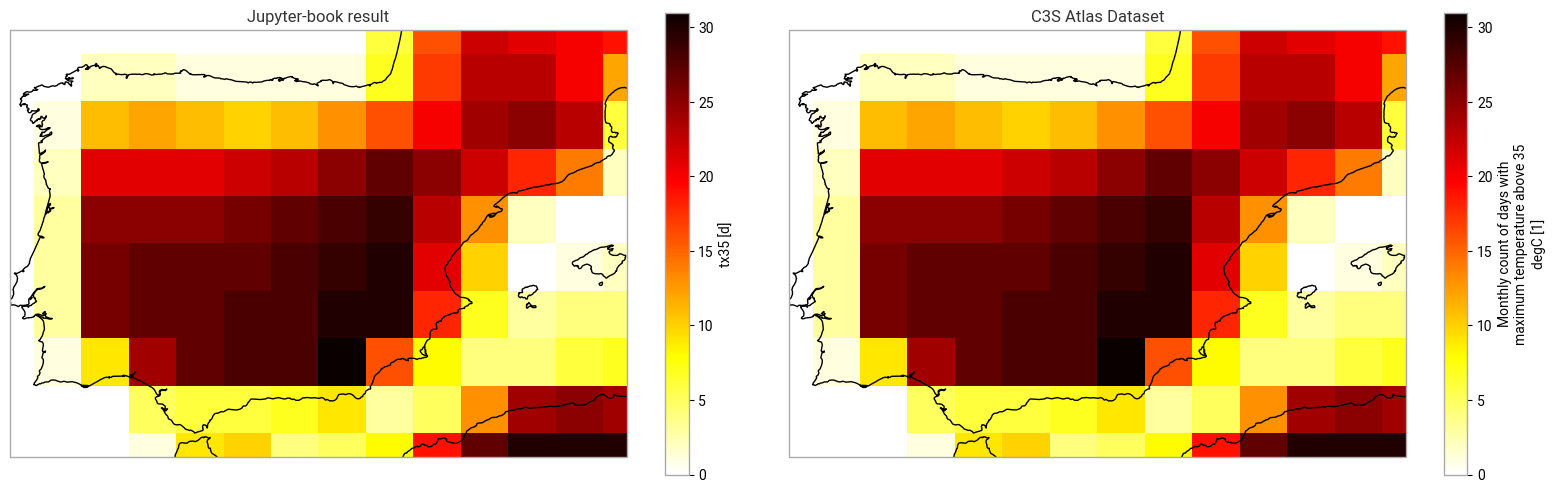

In [11]:
# Plot results 

zoomin_extent = [-9.5, 3.5, 35.5, 44.5]

# zoom for Spain
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': proj}, figsize=(20, 6))

# user-tools
plot_month(ax[0], ds_tx35_i, 'tx35', 8, 'Jupyter-book result', 'hot_r')
ax[0].set_extent(zoomin_extent)

# workflow (intermediate dataset)
plot_month(ax[1], ds_tx35_C3S_Atlas_member_year, 'tx35', 8, 'C3S Atlas Dataset', 'hot_r')
ax[1].set_extent(zoomin_extent)
plt.subplots_adjust(wspace=0.01, hspace=0.1) 

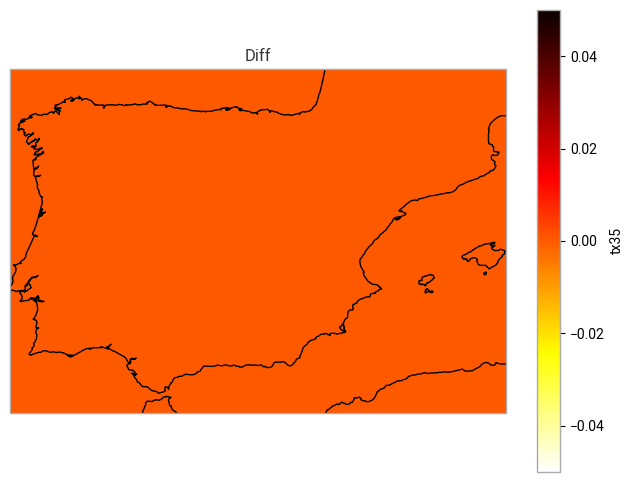

In [12]:
# metric of similarity 

diff = ds_tx35_i - ds_tx35_C3S_Atlas_member_year

ds_tx35_i

#print(ds_tx35_C3S_Atlas_member_year)

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw = {'projection': proj})
#plot_month(ax=ax, diff, 'tx35', 8, 'Diff', 'hot_r')

plot_month(ax, diff, 'tx35', 8, 'Diff', 'hot_r')

ax.set_extent(zoomin_extent)

plt.show()

In [ ]:
# Define request

# define some global attributes for the CDS-API
CMIP6_years = {
    "ssp5_8_5": ["2080"],
}
# variables
variables = {
    't': 'near_surface_air_temperature', 
    'tx': 'daily_maximum_near_surface_air_temperature',
    'tn': 'daily_minimum_near_surface_air_temperature'
}


dataset = "projections-cmip6"
request = {
    "temporal_resolution": "daily",
    "experiment": ['ssp5_8_5'],
    "variable": variables,
    "model": "cmcc_esm2",
    "year": ["2080"],
    "month": [f"{month:02d}" for month in range(1, 13)],
    "day": [f"{day:02d}" for day in range(1, 32)],
    "format": "netcdf"
}

# Download data
ds = earthkit.data.from_source("cds", dataset, request)

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.